#

In [58]:
# v1 - Score : 46.79740
# v2 - Score : 80.27545 (Without dropping any cols)
# v3 : Drop the window column and try again with same data Score: 80.31228
#v4 : v3 + Drop the NA values - 81.63122
# v5: v4 + nestimator as 600  Score: 82.20511
#v6: v5+ nestimator as 700 Score: 82.15082    -- SCORE DROPPEDDDD
# v6.1 : v5 + max depth only as 6 Score: 80.93618  -- SCORE DROPPEDDDD
#v6.2 : v5 + max depth as 8,9,10 : Score:  82.20511
#v6.3 : Score : 82.48

In [59]:
#Import the libraries

import numpy as np;
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Import label encoder
from sklearn import preprocessing

import xgboost as xgb
from xgboost.sklearn import XGBRegressor
import datetime
from sklearn.model_selection import GridSearchCV


#Read train and Testdata

df = pd.read_csv("train.csv",index_col='Property_ID')
df_test = pd.read_csv("test.csv")
X_test = pd.read_csv("test.csv",index_col='Property_ID')

In [60]:
#Find the shape
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39499 entries, 0x21e3 to 0x8cb4
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Property_Type           39499 non-null  object 
 1   Property_Area           39499 non-null  int64  
 2   Number_of_Windows       37845 non-null  float64
 3   Number_of_Doors         39499 non-null  int64  
 4   Furnishing              38457 non-null  object 
 5   Frequency_of_Powercuts  38116 non-null  float64
 6   Power_Backup            39499 non-null  object 
 7   Water_Supply            39499 non-null  object 
 8   Traffic_Density_Score   39499 non-null  float64
 9   Crime_Rate              38712 non-null  object 
 10  Dust_and_Noise          38280 non-null  object 
 11  Air_Quality_Index       39499 non-null  float64
 12  Neighborhood_Review     39499 non-null  float64
 13  Habitability_score      39499 non-null  float64
dtypes: float64(6), int64(2), object(6)
me

There are 13 features in this dataset(Including the target - Habitability Score)
Now find the Null values present in the DB.

In [61]:
df.isna().sum()

Property_Type                0
Property_Area                0
Number_of_Windows         1654
Number_of_Doors              0
Furnishing                1042
Frequency_of_Powercuts    1383
Power_Backup                 0
Water_Supply                 0
Traffic_Density_Score        0
Crime_Rate                 787
Dust_and_Noise            1219
Air_Quality_Index            0
Neighborhood_Review          0
Habitability_score           0
dtype: int64

Null Values are more in the columns - **Number of Windows**, followed by , **Frequency_of_Powercuts**,**Dust_and_Noise** **Furnishing** and **Crime_Rate**
 

In [62]:
print(df['Number_of_Windows'].value_counts())
print(df.Dust_and_Noise.value_counts())


4.0     8053
3.0     7080
2.0     6857
5.0     4708
1.0     4254
7.0     1784
6.0     1738
0.0      699
11.0     363
9.0      352
15.0     336
12.0     336
10.0     335
8.0      326
14.0     316
13.0     308
Name: Number_of_Windows, dtype: int64
Medium    32996
High       3212
Low        2072
Name: Dust_and_Noise, dtype: int64


In [63]:
print(df.Frequency_of_Powercuts.value_counts())
print(df.Crime_Rate.value_counts())

0.0    24471
1.0    10010
2.0     2441
3.0     1194
Name: Frequency_of_Powercuts, dtype: int64
Well below average        19472
Slightly below average    11580
Slightly above average     5303
Well above average         2357
Name: Crime_Rate, dtype: int64


In [64]:
# df['Dust_and_Noise'] = df['Dust_and_Noise'].fillna(df['Dust_and_Noise'].mode()[1])

# df['Crime_Rate'] = df['Crime_Rate'].fillna(df['Crime_Rate'].mode()[1])
 
# df['Frequency_of_Powercuts'] = df['Frequency_of_Powercuts'].fillna(df['Frequency_of_Powercuts'].mode()[1])
# df['Number_of_Windows'] = df['Number_of_Windows'].fillna(df['Number_of_Windows'].mode()[1])
# df['Furnishing'] = df['Furnishing'].fillna(df['Furnishing'].mode()[1])
 
 
df.dropna(subset = ['Dust_and_Noise', 'Crime_Rate', 'Frequency_of_Powercuts', 'Furnishing'])


,Property_Type,Property_Area,Number_of_Windows,Number_of_Doors,Furnishing,Frequency_of_Powercuts,Power_Backup,Water_Supply,Traffic_Density_Score,Crime_Rate,Dust_and_Noise,Air_Quality_Index,Neighborhood_Review,Habitability_score
Property_ID,,,,,,,,,,,,,,
0x21e3,Apartment,106,NaN,1,Semi_Furnished,0.0,No,Once in a day - Morning,5.89,Slightly below average,Medium,90.0,3.86,71.98
0x68d4,Apartment,733,2.0,2,Unfurnished,1.0,No,Once in a day - Evening,4.37,Well below average,Medium,96.0,3.55,71.20
0x7d81,Apartment,737,4.0,2,Fully Furnished,0.0,No,Once in a day - Morning,7.45,Slightly below average,Medium,121.0,3.81,71.39
0x7a57,Apartment,900,3.0,2,Unfurnished,2.0,Yes,Once in a day - Morning,6.16,Well above average,Medium,100.0,1.34,31.46
0x9409,Bungalow,2238,14.0,6,Fully Furnished,0.0,No,All time,5.46,Well below average,Medium,116.0,4.77,93.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0x4bc2,Bungalow,4014,12.0,6,Semi_Furnished,0.0,Yes,All time,7.50,Well below average,Medium,80.0,4.81,86.55
0x5f41,Bungalow,3317,10.0,4,Fully Furnished,2.0,No,All time,4.05,Slightly above average,Medium,101.0,2.29,78.75
0xa013,Apartment,445,1.0,3,Fully Furnished,1.0,No,All time,5.70,Slightly above average,Medium,86.0,2.93,79.91


In [65]:
print(df.Dust_and_Noise.value_counts());
print(df.Crime_Rate.value_counts());
print(df.Frequency_of_Powercuts.value_counts());
print(df.Number_of_Windows.value_counts());
print(df.Furnishing.value_counts());

Medium    32996
High       3212
Low        2072
Name: Dust_and_Noise, dtype: int64
Well below average        19472
Slightly below average    11580
Slightly above average     5303
Well above average         2357
Name: Crime_Rate, dtype: int64
0.0    24471
1.0    10010
2.0     2441
3.0     1194
Name: Frequency_of_Powercuts, dtype: int64
4.0     8053
3.0     7080
2.0     6857
5.0     4708
1.0     4254
7.0     1784
6.0     1738
0.0      699
11.0     363
9.0      352
15.0     336
12.0     336
10.0     335
8.0      326
14.0     316
13.0     308
Name: Number_of_Windows, dtype: int64
Semi_Furnished     20357
Unfurnished        10344
Fully Furnished     7756
Name: Furnishing, dtype: int64


Since thesse columns have Categorical Values , convert them into Numerical Values for easy computations

In [66]:
X = df;
categorical_columns = [col for col in X.columns if  X[col].dtype == "object"]
numerical_cols = [col for col in X.columns if X[col].dtype in ["int64", "float64"]]

 

print(categorical_columns);

print (numerical_cols)

['Property_Type', 'Furnishing', 'Power_Backup', 'Water_Supply', 'Crime_Rate', 'Dust_and_Noise']
['Property_Area', 'Number_of_Windows', 'Number_of_Doors', 'Frequency_of_Powercuts', 'Traffic_Density_Score', 'Air_Quality_Index', 'Neighborhood_Review', 'Habitability_score']


Since we know the categorical features, convert them into numerical for easy calculations. We use **Label Encoding** from **Sckit-learn** to convert them into numerical form
    * Import Label Encoding preprocessor
    *  Apply fit transform on the columns in the dataset 

In [67]:

  
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
  
# Encode labels in column 'Furnishing'.
df['Furnishing']= label_encoder.fit_transform(df['Furnishing'])

# Encode labels in column 'Property_Type'.
df['Property_Type']= label_encoder.fit_transform(df['Property_Type'])


# Encode labels in column 'Power_Backup'.
df['Power_Backup']= label_encoder.fit_transform(df['Power_Backup'])

# Encode labels in column 'Water_Supply'.
df['Water_Supply']= label_encoder.fit_transform(df['Water_Supply'])


# Encode labels in column 'Crime_Rate'.
df['Crime_Rate']= label_encoder.fit_transform(df['Crime_Rate'])
# Encode labels in column 'Dust_and_Noise'.
df['Dust_and_Noise']= label_encoder.fit_transform(df['Dust_and_Noise'])
 

Now find how these columns are correlated using correlation matrix.
**A correlation matrix is simply a table which displays the correlation coefficients for different variables. The matrix depicts the correlation between all the possible pairs of values in a table. It is a powerful tool to summarize a large dataset and to identify and visualize patterns in the given data.**



<AxesSubplot:>

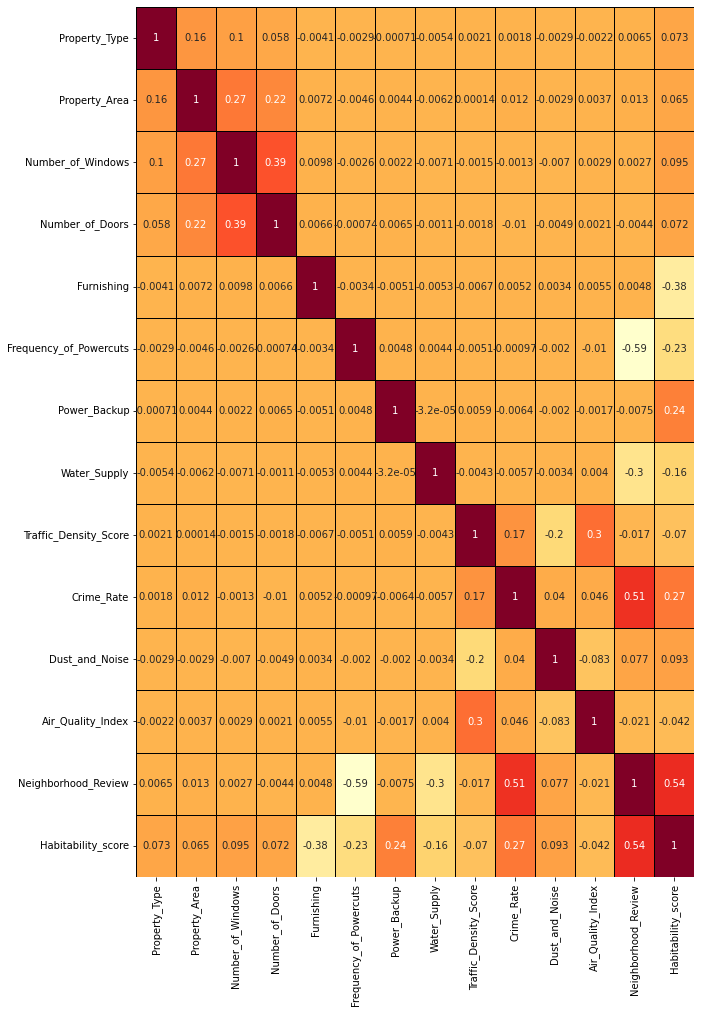

In [68]:
from matplotlib import pyplot
from pandas import read_csv
import numpy
import seaborn as sns
pyplot.figure(figsize=(10, 16))

sns.heatmap(df.corr(), annot=True, linewidth=1, linecolor='black', cmap='YlOrRd', square=False, cbar=False)


Using the above **HeatMap** correlate the values of the Null Columns,

| Columns Having Null Values | Score W.r.t Habitability |
| ---- | ---- |
| Number_of_Windows       | 0.095  |
| Frequency_of_Powercuts | -0.23  |
| Crime_Rate             | 0.27   |      
| Dust_and_Noise         | 0.093  |    
| Furnishing | -0.38|

#### Intrepretation of heatmap
**Frequency_of_Powercuts** is hardly related to Target Variable . This column can be dropped.


In [69]:
#Try without dropping the values

# df.drop(['Frequency_of_Powercuts'],axis=1,inplace=True);
# df.drop(['Furnishing'],axis=1,inplace=True);
df.drop(['Number_of_Windows'],axis=1,inplace=True);
# X_test.drop(['Frequency_of_Powercuts'],axis=1,inplace=True);
# X_test.drop(['Furnishing'],axis=1,inplace=True);
X_test.drop(['Number_of_Windows'],axis=1,inplace=True);



Drop **Furnishing** column 

**Number_of_Windows** - the count of missing values is too high among other and it has many different values. It can also be dropped

Revisit the values of *Crime_Rate* and *Dust_and_Noise*

In [70]:
print(df.Dust_and_Noise.value_counts())
print(df.Crime_Rate.value_counts())

2    32996
0     3212
1     2072
3     1219
Name: Dust_and_Noise, dtype: int64
3    19472
1    11580
0     5303
2     2357
4      787
Name: Crime_Rate, dtype: int64


In [71]:
#Now Drop the target colum from the dataset for modelling

df.dropna(axis=0, subset=['Habitability_score'], inplace=True)

y = df['Habitability_score']             
df.drop(['Habitability_score'], axis=1, inplace=True)

In [72]:
# Various hyper-parameters to tune
xgb1 = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [7,8,9,10],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.8,0.9],
              'n_estimators': [600]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(df,y)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 24 candidates, totalling 48 fits
[15:14:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[15:14:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


0.8125457944360766
{'colsample_bytree': 0.9, 'learning_rate': 0.03, 'max_depth': 10, 'min_child_weight': 4, 'n_estimators': 600, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


In [73]:
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)
#0.8100174198187124 - old value 

0.8125457944360766
{'colsample_bytree': 0.9, 'learning_rate': 0.03, 'max_depth': 10, 'min_child_weight': 4, 'n_estimators': 600, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


In [74]:
from sklearn.pipeline import Pipeline

model_pipeline = Pipeline(steps=[("model_run", xgb_grid)
])

# Fitting the input and predicting the results
model_pipeline.fit(X, y)

Fitting 2 folds for each of 24 candidates, totalling 48 fits
[15:28:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[15:28:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




Pipeline(steps=[('model_run',
                 GridSearchCV(cv=2,
                              estimator=XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     gamma=None, gpu_id=None,
                                                     grow_policy=None,
                                                     importance_type=None,
                                            

In [75]:

# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
  
 

# Encode labels in column 'Property_Type'.
X_test['Property_Type']= label_encoder.fit_transform(X_test['Property_Type'])


# Encode labels in column 'Power_Backup'.
X_test['Power_Backup']= label_encoder.fit_transform(X_test['Power_Backup'])

# Encode labels in column 'Water_Supply'.
X_test['Water_Supply']= label_encoder.fit_transform(X_test['Water_Supply'])


# Encode labels in column 'Crime_Rate'.
X_test['Crime_Rate']= label_encoder.fit_transform(X_test['Crime_Rate'])
# Encode labels in column 'Dust_and_Noise'.
X_test['Dust_and_Noise']= label_encoder.fit_transform(X_test['Dust_and_Noise'])

# Encode labels in column 'Dust_and_Noise'.
X_test['Furnishing']= label_encoder.fit_transform(X_test['Furnishing'])

# Model Prediction
preds = model_pipeline.predict(X_test,)


In [76]:
output = pd.DataFrame({"Property_ID": X_test.index, "Habitability_score": preds})
output.to_csv("submission-13Aug-xgbBoost-gridCV-AllColumns.csv", index=False)
output.head()

,Property_ID,Habitability_score
0,0x6e93,28.488100
1,0x8787,80.047668
2,0x6c17,67.246414
3,0x9dbd,72.225136
4,0xbfde,75.507965
